In [54]:
import sys
if 'ipykernel_launcher.py' not in sys.argv[0]:
    manual = False
    scenario = sys.argv[1]
else:
    manual = True
    scenario = 'ref_18'
    %matplotlib inline

In [55]:
import geopandas as gpd
import pandas as pd
import numpy as np

work_path = r'../../../'
quetzal_path = work_path + r'quetzal_santo_domingo/model/'

plot_path = work_path + r'plot/scenarios/'
import sys
sys.path.insert(0, '../../../quetzal/')

from quetzal.model import stepmodel

In [56]:
from shapely import geometry

In [57]:
sm =  stepmodel.read_zip(quetzal_path + scenario +  '/assigned.zip')

zones: 100%|██████████| 35/35 [00:12<00:00,  2.90it/s]           


In [58]:
sm.volumes.loc[sm.volumes['origin'] == sm.volumes['destination'], ['car', 'nocar']] = 0 

In [59]:
pt = list(sm.mode_nests.reset_index().set_index('root').loc['pt']['route_type'])
print(pt)

['minibus', 'bus', 'concho', 'gondola', 'subway']


In [60]:
from imp import reload
from quetzal.model import summarymodel
reload(summarymodel)

<module 'quetzal.model.summarymodel' from 'c:\\Users\\qchasserieau\\quetzal_quartz\\quetzal_santo_domingo\\notebooks\\transport\\../../../quetzal\\quetzal\\model\\summarymodel.py'>

In [61]:
sm.los['od_fares'] = [{} for i in sm.los.index]

In [62]:
sm.fare_rules

,fare_id,route_id
0,concho,CP_C100_1
1,concho,CP_C100_2
2,concho,CP_C101E_1
3,concho,CP_C101E_2
4,concho,CP_C102_1
...,...,...
410,bus,AB_A20B_2
411,bus,AB_A31_1
412,bus,AB_A31_2
413,bus,AB_A69_1


In [63]:
sm.fare_attributes['agency_id'] = 'SITP'
sm.fare_attributes.loc[sm.fare_attributes['fare_id'].isin(['minibus', 'concho']), 'agency_id'] = 'informal'

In [64]:
sm.loaded_links = sm.links.copy()
sm.summary_link_max(inplace=True)
sm.summary_link_sum(inplace=True)
sm.summary_path_sum(inplace=True, dense=True)
sm.summary_path_average(inplace=True, dense=True)
sm.summary_aggregated_path_average(inplace=True, pt_route_types=pt)
sm.summary_earning(inplace=True, dense=True)

# INTEGRACIÓN TARIFARIA

In [65]:
self = sm.copy()
pt = ['concho', 'gondola', 'tram', 'express_bus', 'bus', 'subway', 'minibus']
costs=['price', 'time', 'in_vehicle_time', 'in_vehicle_length', 'ntransfers']
left = self.los[costs + ['origin', 'volume', 'route_type']].copy()
left.loc[left['route_type'].isin(pt), 'route_type'] = 'pt'
df = pd.merge(left, sm.zones[['municipio']], left_on=['origin'], right_index=True)
df['count'] = 1
munisum = df.groupby([ 'route_type','municipio',])[costs + ['count']].agg(lambda s: (s*df['volume']).sum())

In [66]:
pt_share = munisum.loc['pt']['count'] / munisum.groupby(level=1)['count'].sum()
pt_share['gran santo domingo'] = df.groupby(['route_type'])['volume'].sum()['pt'] / df['volume'].sum()
pt_share.index = pd.MultiIndex.from_tuples(('pt_share', i) for i in pt_share.index)
pt_share

pt_share  los alcarrizos             0.343863
          santo domingo de guzman    0.322349
          santo domingo este         0.387069
          santo domingo norte        0.470167
          santo domingo oeste        0.318703
          gran santo domingo         0.359931
Name: count, dtype: float64

In [67]:
sm.fare_attributes

,fare_id,price,transfers,agency_id
0,bus,15.0,0.0,SITP
1,concho,25.0,0.0,informal
2,express_bus,20.0,0.0,SITP
3,f0,1000.0,0.0,SITP
4,f1,1000.0,1.0,SITP
5,f2,1000.0,2.0,SITP
6,f3,1000.0,3.0,SITP
7,f4,1000.0,4.0,SITP
8,f5,1000.0,5.0,SITP
9,fn,1000.0,10.0,SITP


In [68]:
transfer_rate = sm.stack_aggregated_path_average['pt', 'ntransfers']

In [69]:
tapin = {rid : 0 for rid in set(sm.links['route_id'])}
for arod_list, volume in self.los[['arod_list', 'volume']].dropna().values:
   for a, route_id, o, d in arod_list:
      tapin[route_id] += volume

In [70]:
route_tapin = tapin
mode_tapin = {}
route_type_dict = self.links.groupby(['route_id'])['route_type'].first().to_dict()
for route, volume in route_tapin.items():
    mode = route_type_dict[route]
    try :
        mode_tapin[mode] += volume
    except KeyError:
        mode_tapin[mode] = volume


,bus,concho,gondola,minibus,subway,SITP,informal
boarding,41135,48505,3303,59843,32345,76784,108349
voykm,213123,125238,14441,244841,166259,393823,370080
validation,41135,48505,2768,59843,20834,64739,108349


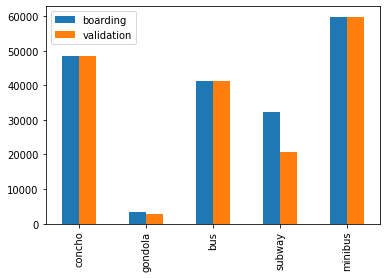

In [74]:
demanda = pd.DataFrame({
    'boarding' : sm.links.groupby(['route_type'])['boardings'].sum(),
    'voykm' : sm.links.groupby(['route_type'])['length'].apply(lambda s: (s*sm.links['volume']).sum()) / 1000,
    'validation' : mode_tapin
})
demanda.loc['SITP'] = demanda.reindex([m for m in pt if m not in ['concho', 'minibus']]).sum()
demanda.loc['informal'] = demanda.reindex([m for m in pt if m in ['concho', 'minibus']]).sum()
demanda.reindex(pt)[['boarding', 'validation']].dropna().plot(kind='bar')
demanda.T.astype(int)

In [75]:
earnings = self.stack_earning.copy()
earnings.index = pd.MultiIndex.from_tuples(('earnings', i) for i in earnings.index)

In [82]:
summary = pd.concat([
    np.round(pt_share, 3), 
    np.round(demanda.T.stack(), -2),
    np.round(pd.Series(transfer_rate, index=[('transfer_rate', 'gran santo domingo')]), 3),
    np.round(earnings, -3), 
])

summary = pd.concat([
    pt_share, 
    demanda.T.stack(), 
    pd.Series(transfer_rate, index=[('transfer_rate', 'gran santo domingo')]),
    earnings, 
])
summary.index.names = ['name', 'filter']
summary.name = 'value'
summary
sm.stack_summary = summary

<AxesSubplot:ylabel='fare_id'>

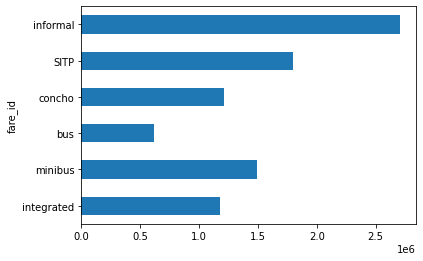

In [83]:
sm.stack_earning.plot(kind='barh')

# Buffer

In [84]:
def buffer_stack(sm, route_types=()):
    sm = sm.copy()
    r = range(1,11)
    
    heavy_nodes = set(sm.links.loc[sm.links['route_type'].isin(route_types)]['a'])
    for b in r:
        buffer = geometry.MultiPoint(list(sm.nodes.loc[heavy_nodes]['geometry'])).buffer(b * 100)

        def in_buffer_ratio(geometry):
            return (geometry.intersection(buffer).area) / geometry.area

        sm.zones['ib' + str(b * 100)] = sm.zones['geometry'].apply(in_buffer_ratio)
    right = sm.zones[['ib' + str(b * 100) for b in r]].apply(lambda c: c*sm.zones['pop'])
    right.columns = [i * 100 for i in list(r)]
    
    tot = sm.zones['pop'].sum()
    s = right.sum() / tot
    s.name = 'ratio'
    s.index.name = 'distance'
    return s

if True:
    sm.stack_buffer = buffer_stack(sm, route_types=['subway', 'tram', 'express_bus', 'gondola'])

In [85]:
sm.to_excel(quetzal_path + scenario + '/stacks.xlsx')

name           filter                 
pt_share       los alcarrizos             3.438635e-01
               santo domingo de guzman    3.223490e-01
               santo domingo este         3.870693e-01
               santo domingo norte        4.701667e-01
               santo domingo oeste        3.187028e-01
               gran santo domingo         3.599309e-01
boarding       bus                        4.113557e+04
               concho                     4.850540e+04
               gondola                    3.303921e+03
               minibus                    5.984371e+04
               subway                     3.234540e+04
               SITP                       7.678489e+04
               informal                   1.083491e+05
voykm          bus                        2.131230e+05
               concho                     1.252389e+05
               gondola                    1.444106e+04
               minibus                    2.448412e+05
               subway     